In [1]:
from collections import Counter
import json
from pathlib import Path
import typing as tp

import matplotlib.pyplot as plt

from data import get_all_data

In [2]:
OUTPUT = Path("./outputs")
PATIENCE = 10
EPOCHS = 50

ARCHITECTURES = ("CNN", "LSTM", "GRU")
OPTIMIZERS = ("SGD", "RMSprop", "Adam", "AdaMax")
LEARNING_RATES = (0.001, 0.01, 0.1)
DROPOUT_RATES = (0.0, 0.1, 0.2, 0.3, 0.4, 0.5)

COLORS = ("red", "blue", "green", "orange", "purple", "black")
MARKERS = (".", "1", "+", "*", "2", "x")

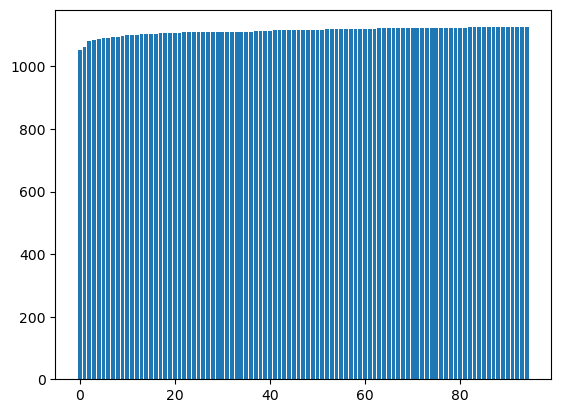

In [77]:
X, y = get_all_data("./data/full")

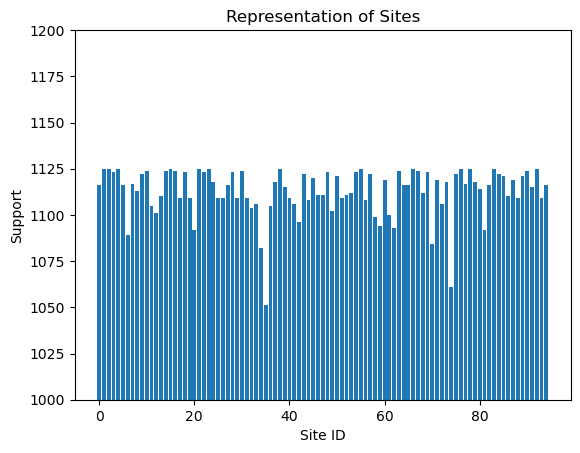

In [85]:
counter = Counter(y.tolist())
sites, counts = list(zip(*counter.items()))
plt.bar(x=sites, height=counts)
plt.title("Representation of Sites")
plt.xlabel("Site ID")
plt.ylabel("Support")
plt.ylim(1000, 1200)
plt.show()
plt.savefig("./graphs/support.png", dpi=400)
plt.close()

In [3]:
def extract_tf_data(report_json: Path, history_json: Path):
    with open(report_json) as handle:
        report = json.load(handle)
    with open(history_json) as handle:
        history = json.load(handle)
    return report, history


def extract_pt_data(report_json: Path, reports_path: Path):
    with open(report_json) as handle:
        report = json.load(handle)

    hist = []
    for p in sorted(reports_path.iterdir(), key=lambda p: int(p.stem)):
        with open(p) as handle:
            hist.append(json.load(handle))

    history = {k : [] for k in report.keys()}
    for h in hist:
        for k in report.keys():
            history[k].append(h[k])

    return report, history

In [8]:
r, h = extract_tf_data("outputs/Adam/0.001/0.0/CNN/4/elu/report.json", "outputs/Adam/0.001/0.0/CNN/4/elu/history.json")

{'loss': [1.5571789741516113,
  0.5686132311820984,
  0.4148797392845154,
  0.34238380193710327,
  0.31179651618003845,
  0.28286340832710266,
  0.2674599289894104,
  0.25815242528915405,
  0.2476261705160141,
  0.2421196848154068,
  0.2319594919681549,
  0.22529493272304535,
  0.21787147223949432,
  0.2187492549419403,
  0.2136959731578827,
  0.20634275674819946,
  0.2051382064819336,
  0.1983269602060318],
 'accuracy': [1.6592902056800085e-06,
  8.075212463154458e-06,
  2.4446875613648444e-05,
  5.0884900701930746e-05,
  0.00010431404371047392,
  0.000159291856107302,
  0.00021957940771244466,
  0.0003161500790156424,
  0.000396349118091166,
  0.0004887162940576673,
  0.0006081851897761226,
  0.0006960169412195683,
  0.0007929194835014641,
  0.0008803087403066456,
  0.0009884944884106517,
  0.0010478970361873507,
  0.0011257730657234788,
  0.0012319677043706179],
 'auc': [0.9606927037239075,
  0.9900355935096741,
  0.9933528304100037,
  0.9950705170631409,
  0.9957465529441833,
  0.9

In [13]:
def find_best_val_metric(o: str, l: float, d: float, arch: tp.Literal["RNN", "LSTM", "GRU"], metric: str = "accuracy") -> float:
    p = OUTPUT / o / str(l) / str(d) / arch
    if arch in ("CNN",):
        try:
            report_json = next(p.rglob("report.json"))
            history_json = next(p.rglob("history.json"))
        except StopIteration:
            raise FileNotFoundError()
        ts_report, vl_reports = extract_tf_data(report_json, history_json)
        epochs = len(next(iter(vl_reports.values())))
    elif arch in ("RNN", "LSTM", "GRU"):
        try:
            report_json = next(p.rglob("report.json"))
        except StopIteration:
            raise FileNotFoundError()
        reports_path = next(p.rglob("reports"))
        ts_report, vl_reports = extract_pt_data(report_json, reports_path)
        epochs = sum(1 for _ in reports_path.iterdir())
    b = epochs - PATIENCE if epochs != EPOCHS else EPOCHS
    vl_report = {k : v[b - 1] for k, v in vl_reports.items()}
    return vl_report[metric]


def plot_best_vl_accuracy(arch: tp.Literal["RNN", "LSTM", "GRU"], metric: str = "accuracy"):
    for i, o in enumerate(OPTIMIZERS):
        for j, l in enumerate(LEARNING_RATES):
            x = []
            y = []
            for k, d in enumerate(DROPOUT_RATES):
                try:
                    a = find_best_val_metric(o, l, d, arch, metric)
                except FileNotFoundError:
                    continue
                x.append(d)
                y.append(a)
            plt.scatter(x=x, y=y, color=COLORS[j], marker=MARKERS[j], label=l)
        plt.title(f"{o} Optimizer")
        plt.ylim([0, 1])
        plt.xlabel("Dropout Rate")
        plt.ylabel(f"Best Validation {metric.capitalize()}")
        plt.legend(title="Learning Rate")
        plt.show()
        plt.savefig(f"graphs/{arch}_{o}.png", dpi=400)
        plt.close()

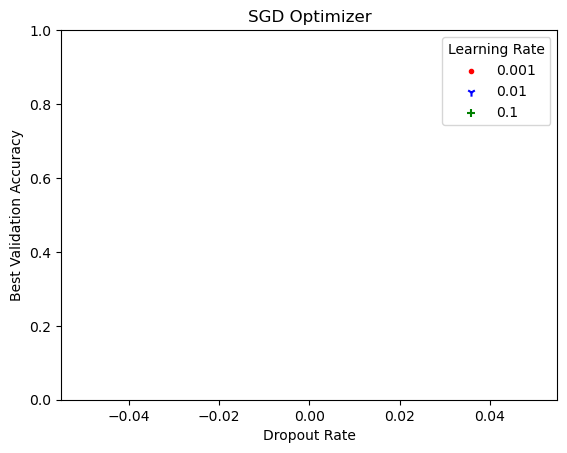

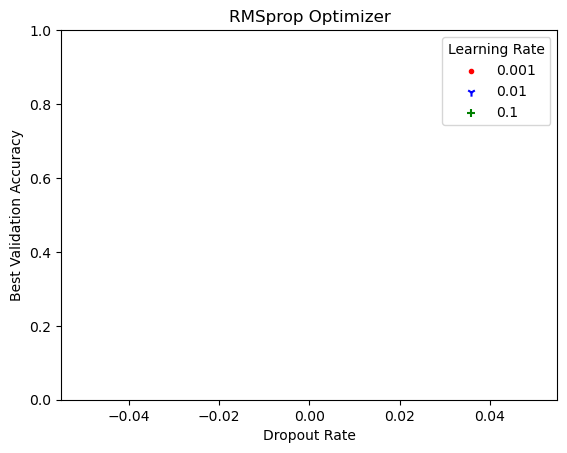

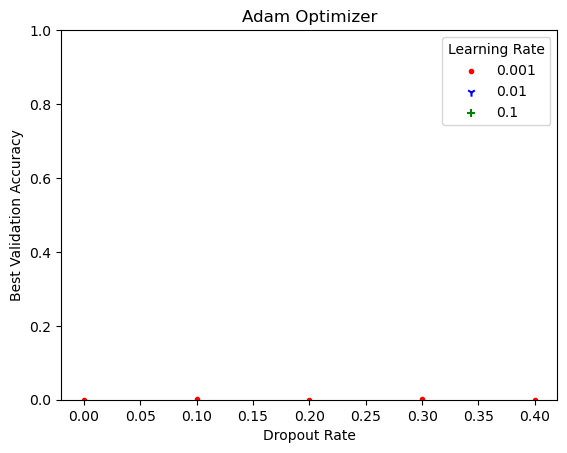

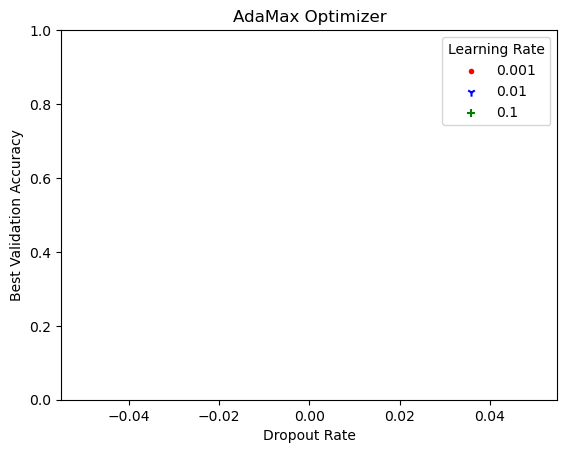

In [14]:
plot_best_vl_accuracy("CNN")
# plot_best_vl_accuracy("LSTM")
# plot_best_vl_accuracy("GRU")

In [5]:
def best_ts_metric(arch: tp.Literal["RNN", "LSTM", "GRU"], metric: str = "accuracy"):
    accuracies = []
    for i, o in enumerate(OPTIMIZERS):
        for j, l in enumerate(LEARNING_RATES):
            for k, d in enumerate(DROPOUT_RATES):
                try:
                    a = find_best_val_metric(o, l, d, arch, metric)
                except FileNotFoundError:
                    continue
                accuracies.append(((o, l, d), a))

    o, l, d = sorted(accuracies, key=lambda x: x[1], reverse=True)[0][0]
    p = OUTPUT / o / str(l) / str(d) / arch
    if arch in ("CNN",):
        try:
            report_json = next(p.rglob("report.json"))
            history_json = next(p.rglob("history.json"))
        except StopIteration:
            raise FileNotFoundError()
        ts_report, _ = extract_tf_data(report_json, history_json)
    elif arch in ("RNN", "LSTM", "GRU"):
        try:
            report_json = next(p.rglob("report.json"))
        except StopIteration:
            raise FileNotFoundError()
        reports_path = next(p.rglob("reports"))
        ts_report, _ = extract_pt_data(report_json, reports_path)

    return (o, l, d), ts_report[metric]

In [11]:
{
    "CNN": best_ts_metric("CNN"),
    #"LSTM": best_ts_metric("LSTM"),
    #"GRU": best_ts_metric("GRU"),
}

{'CNN': (('Adam', 0.001, 0.3), 0.0032718004658818245)}